In [1]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import datetime as dt
import talib
from tqdm import tqdm
import colorama as col
from bt import *
from sklearn.preprocessing import MinMaxScaler
import pycaret
from pycaret.anomaly import *

print('PyCaret: %s' % pycaret.__version__)


Importing Librairies...
PyCaret: 2.2.0


In [2]:
%%time
##### Chargement de la base
base = pd.read_csv('Base_Clean/EURUSDm5.csv')

##### On fixe la date en index sous forme de Timestamp
base.set_index(pd.to_datetime(base.Date),drop=True,inplace=True)

###### On drop les colonnes inutiles
base = base.drop(['Date','Total'],axis=1)

##### On enlève les jours correspondant au samedi et au dimanche
base['WE'] = np.where(((base.index.weekday == 5) | (base.index.weekday == 6)),None,base.index.weekday)
base = base.dropna()
base = base.drop(['WE'],axis=1)


CPU times: user 2.24 s, sys: 289 ms, total: 2.53 s
Wall time: 2.62 s


In [3]:
base.index[0],base.index[-1]

(Timestamp('2010-11-23 00:00:00'), Timestamp('2020-11-23 15:40:00'))

In [4]:
%%time
_year_bottom = pd.to_datetime('2011-01-01 16:00:00')
_year_top = pd.to_datetime('2015-12-31 16:00:00') #2020-11-23 16:00:00

df = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

CPU times: user 23.5 ms, sys: 17.6 ms, total: 41 ms
Wall time: 43.5 ms


In [5]:
df['HiWin'] = df.High.rolling(10).max()
df['LoWin'] = df.Low.rolling(10).min()
df['JyssOscUp'] = ((df.HiWin-df.HiWin.shift(2))/df.HiWin.shift(2))*1000
df['JyssOscUpSD'] = df.JyssOscUp.rolling(20).std()
df['JyssOscDwn'] = ((df.LoWin-df.LoWin.shift(2))/df.LoWin.shift(2))*1000
df['JyssOscDwnSD'] = df.JyssOscDwn.rolling(20).std()
df['TriggerBull'] = (df.HiWin - df.HiWin.shift(2)) * 1000
df['TriggerBear'] = (df.LoWin - df.LoWin.shift(2)) * 1000
df['Trigger'] = np.where((df.LoWin - df.LoWin.shift(9) == 0),1,np.where((df.HiWin - df.HiWin.shift(9) == 0 ),1,0))

In [6]:
df['Signal'] = np.where(\
    ((df.Close <= 1.01*df.LoWin)&(df.JyssOscUp <= -4*df.JyssOscUpSD)),1,\
        np.where(\
            ((df.Close >= 0.99*df.HiWin)&(df.JyssOscDwn >= 4*df.JyssOscDwnSD)),-1,0)
)
df['SignalClose'] = np.where(\
    ((df.Close >= 0.99*df.HiWin)&(df.JyssOscDwn <= -3*df.JyssOscDwnSD)),1,\
        np.where(\
            ((df.Close <= 1.01*df.LoWin)&(df.JyssOscUp >= 3*df.JyssOscUpSD)),-1,0)
)

In [7]:
_nb_bougie_exit = 96000000
_trigger_reengage = 0
_trigger_target = 0
_trigger_invers = 1
_trigger_sl = 0
_verbose = 0
_cash_ini = 200000
_rate = 1
x = 'EUR/USD'
_target = 0.006
_exposure = 3
_size = 50000
_sl = 0.002
TRACKER = bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl)

Librairies imported

Début des opérations horodatée à 2020-12-15 22:16:25.141420

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 369102/369102 [00:40<00:00, 9221.34it/s]
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  6586.0 !. En  826   transactions.
 
Nbre de winners : 497 
 
Nbre de loosers : 329 
Temps d'excution du BT 0:00:46.660265
 EUR/USD  results 
 Tested Period 2011-01-01 16:00:00  à 2015-12-31 16:00:00 
 Total Number of trades 826 
Started Cash : 50000
P&L  in currency:  6586.0$ 
P&L in %:  3.29% 
Average trade duration 312.57
# Winners  497.0
# Loosers  329.0
Cumulated gains 112227.5
Cumulated losses -105641.5
 PROFIT FACTOR :  1.06 
 Winners Ratio : 60.17 % 
Average Winners 225.81
% Average Winners 0.11
Average Loosers -321.1
% Average Loosers -0.16
Average pnl 7.97
% Average pnl 0.0
Number of opened trades 826
Number of closed trades 826
Max Exposure 1 x

In [8]:
len(TRACKER)

497

In [9]:
%%time
scaler = MinMaxScaler((0,1))
df_2 = df.copy()
df_2['RSI2'] = talib.RSI(df_2.Close,timeperiod=2)
df_2['MMA200'] = talib.EMA(df_2.Close,timeperiod=200)
upper, middle, lower = talib.BBANDS(df_2.Close, timeperiod=10, nbdevup=2, nbdevdn=2)
df_2['SBVol'] = upper - lower
df_2['MMA55'] = talib.EMA(df_2.Close,timeperiod=55)
df_2['MMA80'] = talib.EMA(df_2.Close,timeperiod=80)
df_2['RSI14'] = talib.RSI(df_2.Close,timeperiod=14)


df_2 = df_2.drop(['SignalClose'],axis=1)

df_2.rename(columns = {'Signal':'SigO4bt'}, inplace = True)
SIGNAL = []
SIGNAL = [1 if ((df_2['SigO4bt'][i] != 0) & (df_2.index[i] in TRACKER)) else 0 for i in tqdm(range(len(df_2)))]
df_2['Signal'] = SIGNAL

df_2 = df_2.dropna()

df_2 = df_2.sort_index(axis=1)


100%|██████████| 369132/369132 [00:22<00:00, 16718.47it/s]
CPU times: user 21.8 s, sys: 452 ms, total: 22.3 s
Wall time: 22.6 s


In [10]:
%%time
featuring = setup(df_2.sort_index(axis=1))

,Description,Value
0,session_id,7572
1,Original Data,"(368933, 31)"
2,Missing Values,False
3,Numeric Features,28
4,Categorical Features,3
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(368933, 35)"
9,CPU Jobs,-1


CPU times: user 24.2 s, sys: 2.14 s, total: 26.4 s
Wall time: 2min 6s


In [16]:
%%time
#abod = create_model('abod')
cluster = create_model('cluster')
#cof = create_model('cof')
#histogram = create_model('histogram')
#knn = create_model('knn')
#lof = create_model('lof')
#svm = create_model('svm')
#pca = create_model('pca')
#mcd = create_model('mcd')
#sod = create_model('sod')
#sos = create_model('sos')


CPU times: user 4min 23s, sys: 30.4 s, total: 4min 53s
Wall time: 1min


In [15]:
%%time
#evaluate_model('abod')
evaluate_model('cluster')
#evaluate_model('cof')
#evaluate_model(histogram)
#evaluate_model(knn)
#evaluate_model(lof)
#evaluate_model(svm)
#evaluate_model(pca)
#evaluate_model(mcd)
#evaluate_model(sod)
#evaluate_model(sos)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Anomaly TSnE (3d)', 'tsn…

CPU times: user 77.4 ms, sys: 44.1 ms, total: 121 ms
Wall time: 129 ms


In [ ]:
%%time
abod_df = assign_model('abod')
cluster_df = assign_model('cluster')
cof_df = assign_model('cof')
histogram_df = assign_model('histogram')
knn_df = assign_model('knn')
lof_df = assign_model('lof')
svm_df = assign_model('svm')
pca_df = assign_model('pca')
mcd_df = assign_model('mcd')
sod_df = assign_model('sod')
sos_df = assign_model('sos')


In [19]:
%%time
model_tuned = tune_model(model,optimize='Prec.')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9986,0.9974,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9986,0.9975,0.0400,0.5000,0.0741,0.0739,0.1411
2,0.9986,0.9972,0.0000,0.0000,0.0000,-0.0001,-0.0003
3,0.9985,0.9965,0.0000,0.0000,0.0000,-0.0002,-0.0004
4,0.9985,0.9967,0.0000,0.0000,0.0000,-0.0002,-0.0004
5,0.9987,0.9968,0.0400,1.0000,0.0769,0.0768,0.1999
6,0.9988,0.9977,0.0417,1.0000,0.0800,0.0799,0.2040
7,0.9986,0.9972,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9986,0.9969,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.9987,0.9964,0.0400,1.0000,0.0769,0.0768,0.1999


CPU times: user 1min 24s, sys: 13.1 s, total: 1min 37s
Wall time: 29min 34s


In [20]:
%%time
bagged_model = ensemble_model(model_tuned, method = 'Bagging')

IntProgress(value=0, description='Processing: ', max=6)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,00:54:18
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


In [ ]:
%%time
boosted_model = ensemble_model(model_tuned, method = 'Boosting', n_estimators = 100)

In [ ]:
%%time
interpret_model(model_tuned)

In [ ]:
%%time
interpret_model(bagged_model)

In [ ]:
%%time
interpret_model(boosted_model)

In [ ]:
%%time
calibrated_model = calibrate_model(model_tuned)

In [ ]:
%%time
calibrated_bag = calibrate_model(bagged_model)

In [ ]:
%%time
calibrated_boost = calibrate_model(boosted_model)

In [55]:
dt = create_model('dt',fold=2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9978,0.5313,0.0636,0.0815,0.0714,0.0703,0.0709
1,0.9976,0.5659,0.1329,0.1264,0.1296,0.1284,0.1284
Mean,0.9977,0.5486,0.0983,0.1039,0.1005,0.0994,0.0997
SD,0.0001,0.0173,0.0347,0.0224,0.0291,0.0290,0.0288


In [62]:
tuned_dt = tune_model(dt) #,custom_grid={'ccp_alpha':0.0, 'class_weight':None, 'criterion':'gini',
                        #'max_depth':None, 'max_features':None, 'max_leaf_nodes':None,
                        #'min_impurity_decrease':0.0, 'min_impurity_split':None,
                        #'min_samples_leaf':1, 'min_samples_split':2,
                        #'min_weight_fraction_leaf':0.0, 'presort':'deprecated',
                        #'random_state':555, 'splitter':'best'})

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9986,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9986,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9986,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9987,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9987,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9987,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9987,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9986,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9986,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.9986,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


In [24]:
print(tuned_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=49, p=2,
                     weights='uniform')


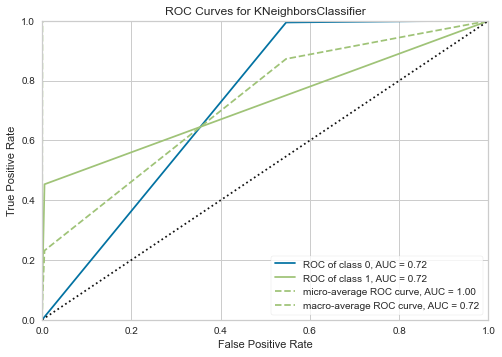

In [28]:
plot_model(tuned_knn,'auc')

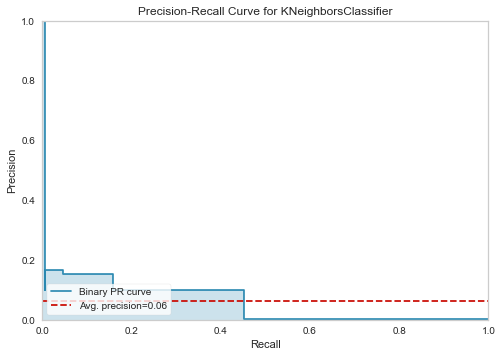

In [29]:
plot_model(tuned_knn,'pr')

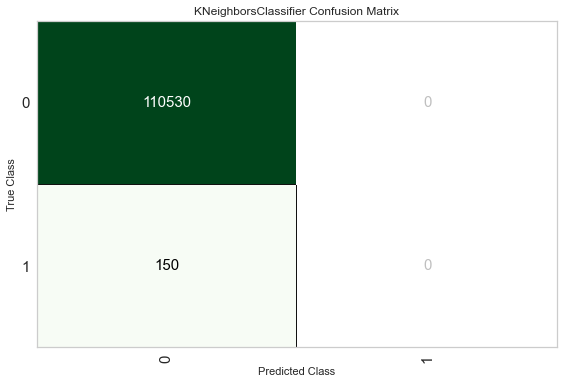

In [31]:
plot_model(tuned_knn, plot='confusion_matrix')

In [32]:
evaluate_model(tuned_knn)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

IntProgress(value=0, description='Processing: ', max=5)

In [44]:
%%time


# setup the dataset
grid = setup(data=df_2.sort_index(axis=1), target='Signal', html=False, silent=True, verbose=True, feature_selection = True,feature_selection_threshold=0.7,remove_multicollinearity = True, multicollinearity_threshold = 0.6, pca = True)

# evaluate models and compare models
best = compare_models()

# report the best model
print(best)

PyCaret: 2.2.0
Setup Succesfully Completed!


,Description,Value
0,session_id,7643
1,Target,Signal
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(18422, 27)"
5,Missing Values,False
6,Numeric Features,23
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0,0.0,0.407


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0,0.0,0.407
knn,K Neighbors Classifier,0.9964,0.4909,0.0,0.0,0.0,0.0,0.0,0.056


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0,0.0,0.407
knn,K Neighbors Classifier,0.9964,0.4909,0.0,0.0,0.0,0.0,0.0,0.056
nb,Naive Bayes,0.9964,0.4986,0.0,0.0,0.0,0.0,0.0,0.009


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.407
knn,K Neighbors Classifier,0.9964,0.4909,0.0,0.0,0.0,0.0000,0.0000,0.056
nb,Naive Bayes,0.9964,0.4986,0.0,0.0,0.0,0.0000,0.0000,0.009
dt,Decision Tree Classifier,0.9923,0.4979,0.0,0.0,0.0,-0.0036,-0.0037,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.407
knn,K Neighbors Classifier,0.9964,0.4909,0.0,0.0,0.0,0.0000,0.0000,0.056
nb,Naive Bayes,0.9964,0.4986,0.0,0.0,0.0,0.0000,0.0000,0.009
svm,SVM - Linear Kernel,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.013
dt,Decision Tree Classifier,0.9923,0.4979,0.0,0.0,0.0,-0.0036,-0.0037,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.407
knn,K Neighbors Classifier,0.9964,0.4909,0.0,0.0,0.0,0.0000,0.0000,0.056
nb,Naive Bayes,0.9964,0.4986,0.0,0.0,0.0,0.0000,0.0000,0.009
svm,SVM - Linear Kernel,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.013
ridge,Ridge Classifier,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.009
dt,Decision Tree Classifier,0.9923,0.4979,0.0,0.0,0.0,-0.0036,-0.0037,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.407
knn,K Neighbors Classifier,0.9964,0.4909,0.0,0.0,0.0,0.0000,0.0000,0.056
nb,Naive Bayes,0.9964,0.4986,0.0,0.0,0.0,0.0000,0.0000,0.009
svm,SVM - Linear Kernel,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.013
ridge,Ridge Classifier,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.009
dt,Decision Tree Classifier,0.9923,0.4979,0.0,0.0,0.0,-0.0036,-0.0037,0.015
rf,Random Forest Classifier,0.9923,0.4906,0.0,0.0,0.0,-0.0036,-0.0037,0.376


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.407
knn,K Neighbors Classifier,0.9964,0.4909,0.0,0.0,0.0,0.0000,0.0000,0.056
nb,Naive Bayes,0.9964,0.4986,0.0,0.0,0.0,0.0000,0.0000,0.009
svm,SVM - Linear Kernel,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.013
ridge,Ridge Classifier,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.009
qda,Quadratic Discriminant Analysis,0.9964,0.4894,0.0,0.0,0.0,0.0000,0.0000,0.012
dt,Decision Tree Classifier,0.9923,0.4979,0.0,0.0,0.0,-0.0036,-0.0037,0.015
rf,Random Forest Classifier,0.9923,0.4906,0.0,0.0,0.0,-0.0036,-0.0037,0.376


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.407
knn,K Neighbors Classifier,0.9964,0.4909,0.0,0.0,0.0,0.0000,0.0000,0.056
nb,Naive Bayes,0.9964,0.4986,0.0,0.0,0.0,0.0000,0.0000,0.009
svm,SVM - Linear Kernel,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.013
ridge,Ridge Classifier,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.009
qda,Quadratic Discriminant Analysis,0.9964,0.4894,0.0,0.0,0.0,0.0000,0.0000,0.012
ada,Ada Boost Classifier,0.9962,0.5225,0.0,0.0,0.0,-0.0004,-0.0005,0.082
dt,Decision Tree Classifier,0.9923,0.4979,0.0,0.0,0.0,-0.0036,-0.0037,0.015
rf,Random Forest Classifier,0.9923,0.4906,0.0,0.0,0.0,-0.0036,-0.0037,0.376


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.407
knn,K Neighbors Classifier,0.9964,0.4909,0.0,0.0,0.0,0.0000,0.0000,0.056
nb,Naive Bayes,0.9964,0.4986,0.0,0.0,0.0,0.0000,0.0000,0.009
svm,SVM - Linear Kernel,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.013
ridge,Ridge Classifier,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.009
qda,Quadratic Discriminant Analysis,0.9964,0.4894,0.0,0.0,0.0,0.0000,0.0000,0.012
ada,Ada Boost Classifier,0.9962,0.5225,0.0,0.0,0.0,-0.0004,-0.0005,0.082
dt,Decision Tree Classifier,0.9923,0.4979,0.0,0.0,0.0,-0.0036,-0.0037,0.015
rf,Random Forest Classifier,0.9923,0.4906,0.0,0.0,0.0,-0.0036,-0.0037,0.376
gbc,Gradient Boosting Classifier,0.9923,0.4605,0.0,0.0,0.0,-0.0036,-0.0037,0.176


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.407
knn,K Neighbors Classifier,0.9964,0.4909,0.0,0.0,0.0,0.0000,0.0000,0.056
nb,Naive Bayes,0.9964,0.4986,0.0,0.0,0.0,0.0000,0.0000,0.009
svm,SVM - Linear Kernel,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.013
ridge,Ridge Classifier,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.009
qda,Quadratic Discriminant Analysis,0.9964,0.4894,0.0,0.0,0.0,0.0000,0.0000,0.012
lda,Linear Discriminant Analysis,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.014
ada,Ada Boost Classifier,0.9962,0.5225,0.0,0.0,0.0,-0.0004,-0.0005,0.082
dt,Decision Tree Classifier,0.9923,0.4979,0.0,0.0,0.0,-0.0036,-0.0037,0.015
rf,Random Forest Classifier,0.9923,0.4906,0.0,0.0,0.0,-0.0036,-0.0037,0.376


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.407
knn,K Neighbors Classifier,0.9964,0.4909,0.0,0.0,0.0,0.0000,0.0000,0.056
nb,Naive Bayes,0.9964,0.4986,0.0,0.0,0.0,0.0000,0.0000,0.009
svm,SVM - Linear Kernel,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.013
ridge,Ridge Classifier,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.009
qda,Quadratic Discriminant Analysis,0.9964,0.4894,0.0,0.0,0.0,0.0000,0.0000,0.012
lda,Linear Discriminant Analysis,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.014
ada,Ada Boost Classifier,0.9962,0.5225,0.0,0.0,0.0,-0.0004,-0.0005,0.082
dt,Decision Tree Classifier,0.9923,0.4979,0.0,0.0,0.0,-0.0036,-0.0037,0.015
rf,Random Forest Classifier,0.9923,0.4906,0.0,0.0,0.0,-0.0036,-0.0037,0.376


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.407
knn,K Neighbors Classifier,0.9964,0.4909,0.0,0.0,0.0,0.0000,0.0000,0.056
nb,Naive Bayes,0.9964,0.4986,0.0,0.0,0.0,0.0000,0.0000,0.009
svm,SVM - Linear Kernel,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.013
ridge,Ridge Classifier,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.009
qda,Quadratic Discriminant Analysis,0.9964,0.4894,0.0,0.0,0.0,0.0000,0.0000,0.012
lda,Linear Discriminant Analysis,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.014
ada,Ada Boost Classifier,0.9962,0.5225,0.0,0.0,0.0,-0.0004,-0.0005,0.082
dt,Decision Tree Classifier,0.9923,0.4979,0.0,0.0,0.0,-0.0036,-0.0037,0.015
rf,Random Forest Classifier,0.9923,0.4906,0.0,0.0,0.0,-0.0036,-0.0037,0.376


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.407
knn,K Neighbors Classifier,0.9964,0.4909,0.0,0.0,0.0,0.0000,0.0000,0.056
nb,Naive Bayes,0.9964,0.4986,0.0,0.0,0.0,0.0000,0.0000,0.009
svm,SVM - Linear Kernel,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.013
ridge,Ridge Classifier,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.009
qda,Quadratic Discriminant Analysis,0.9964,0.4894,0.0,0.0,0.0,0.0000,0.0000,0.012
lda,Linear Discriminant Analysis,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.014
lightgbm,Light Gradient Boosting Machine,0.9964,0.4564,0.0,0.0,0.0,0.0000,0.0000,0.053
ada,Ada Boost Classifier,0.9962,0.5225,0.0,0.0,0.0,-0.0004,-0.0005,0.082
dt,Decision Tree Classifier,0.9923,0.4979,0.0,0.0,0.0,-0.0036,-0.0037,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.407
knn,K Neighbors Classifier,0.9964,0.4909,0.0,0.0,0.0,0.0000,0.0000,0.056
nb,Naive Bayes,0.9964,0.4986,0.0,0.0,0.0,0.0000,0.0000,0.009
svm,SVM - Linear Kernel,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.013
ridge,Ridge Classifier,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.009
qda,Quadratic Discriminant Analysis,0.9964,0.4894,0.0,0.0,0.0,0.0000,0.0000,0.012
lda,Linear Discriminant Analysis,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.014
lightgbm,Light Gradient Boosting Machine,0.9964,0.4564,0.0,0.0,0.0,0.0000,0.0000,0.053
catboost,CatBoost Classifier,0.9964,0.4843,0.0,0.0,0.0,0.0000,0.0000,10.314
ada,Ada Boost Classifier,0.9962,0.5225,0.0,0.0,0.0,-0.0004,-0.0005,0.082


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.407
knn,K Neighbors Classifier,0.9964,0.4909,0.0,0.0,0.0,0.0000,0.0000,0.056
nb,Naive Bayes,0.9964,0.4986,0.0,0.0,0.0,0.0000,0.0000,0.009
svm,SVM - Linear Kernel,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.013
ridge,Ridge Classifier,0.9964,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.009
qda,Quadratic Discriminant Analysis,0.9964,0.4894,0.0,0.0,0.0,0.0000,0.0000,0.012
lda,Linear Discriminant Analysis,0.9964,0.4024,0.0,0.0,0.0,0.0000,0.0000,0.014
lightgbm,Light Gradient Boosting Machine,0.9964,0.4564,0.0,0.0,0.0,0.0000,0.0000,0.053
catboost,CatBoost Classifier,0.9964,0.4843,0.0,0.0,0.0,0.0000,0.0000,10.314
ada,Ada Boost Classifier,0.9962,0.5225,0.0,0.0,0.0,-0.0004,-0.0005,0.082


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7643, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
CPU times: user 8.14 s, sys: 795 ms, total: 8.93 s
Wall time: 2min 2s


In [98]:
from etc import modelize
_model = 'etc'
modelize(df_2[(df_2.SigO4bt != 0)],x,_model,0)

 Extra Trees Classifier pour  EUR/USD 
[0 1]
Signaux achat Counter({0: 148, 1: 130})
 Pour  EUR/USD 

Achat - Accuracy : 54.87 %
Achat - Precision : 51.52 %
Achat - Recall : 56.04 %
Achat - F-measure: : 53.68 % 


              precision    recall  f1-score   support

           0       0.58      0.54      0.56       104
           1       0.52      0.56      0.54        91

    accuracy                           0.55       195
   macro avg       0.55      0.55      0.55       195
weighted avg       0.55      0.55      0.55       195

              Vrais_estimés    Faux_estimés
vrais_réels  Vrais_positifs    Faux_négatif
Faux_réels    Faux_positifs  Vrais-négatifs
[[56 48]
 [40 51]]


 Joblib Model  JOBLIB/etc/SaveEURUSDm5.sav  dumped to disk 
Best Threshold=0.000000, F-Score=0.636


()

In [100]:
%%time
print('Modèle retenu, ',_model)
_year_bottom = pd.to_datetime('2016-01-01 16:00:00')
_year_top = pd.to_datetime('2020-11-23 16:00:00') #2020-11-23 16:00:00

df_oos = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

df_oos['HiWin'] = df_oos.High.rolling(10).max()
df_oos['LoWin'] = df_oos.Low.rolling(10).min()
df_oos['JyssOscUp'] = ((df_oos.HiWin - df_oos.HiWin.shift(2)) / df_oos.HiWin.shift(2))*1000
df_oos['JyssOscUpSD'] = df_oos.JyssOscUp.rolling(20).std()
df_oos['JyssOscDwn'] = ((df_oos.LoWin - df_oos.LoWin.shift(2)) / df_oos.LoWin.shift(2))*1000
df_oos['JyssOscDwnSD'] = df_oos.JyssOscDwn.rolling(20).std()
df_oos['TriggerBull'] = (df_oos.HiWin - df_oos.HiWin.shift(2)) * 1000
df_oos['TriggerBear'] = (df_oos.LoWin - df_oos.LoWin.shift(2)) * 1000
df_oos['Trigger'] = np.where((df_oos.LoWin - df_oos.LoWin.shift(9) == 0),1,np.where((df_oos.HiWin - df_oos.HiWin.shift(9) == 0 ),1,0))
df_oos['RSI2'] = talib.RSI(df_oos.Close,timeperiod=2)
df_oos['MMA200'] = talib.EMA(df_oos.Close,timeperiod=80)
upper, middle, lower = talib.BBANDS(df_oos.Close, timeperiod=10, nbdevup=2, nbdevdn=2)
df_oos['SBVol'] = upper - lower

df_oos['Signal'] = np.where(\
    ((df_oos.Close <= 1.01 * df_oos.LoWin) & (df_oos.JyssOscUp <= -4*df_oos.JyssOscUpSD)),1,\
        np.where(\
            ((df_oos.Close >= 0.99 * df_oos.HiWin) & (df_oos.JyssOscDwn >= 4*df_oos.JyssOscDwnSD)),-1,0)
)
df_oos['SignalClose'] = np.where(\
    ((df_oos.Close >= 0.99 * df_oos.HiWin) & (df_oos.JyssOscDwn <= -3 * df_oos.JyssOscDwnSD)),1,\
        np.where(\
            ((df_oos.Close <= 1.01 * df_oos.LoWin) & (df_oos.JyssOscUp >= 3 * df_oos.JyssOscUpSD)),-1,0)
)


df_oos = df_oos.drop(['SignalClose'],axis=1)
df_oos.rename(columns = {'Signal':'Sig4bt'}, inplace = True)

loaded_model = joblib.load('JOBLIB/'+_model+'/SaveEURUSDm5.sav')
df_oos = df_oos.dropna()
df_oos = df_oos.sort_index(axis=1)
#df_oos['Signal_hat'] = loaded_model.predict(scaler.fit_transform(df_oos[['HiWin','LoWin','JyssOscUp','JyssOscUpSD','JyssOscDwn','JyssOscDwnSD',\
#                                    'TriggerBull','TriggerBear','Trigger','Sig4bt']].values))

df_oos['Signal_hat'] = loaded_model.predict(df_oos)

df_oos['Signal'] = np.where(
                            ((df_oos.Sig4bt == 1)&(df_oos.Signal_hat==1)),1,\
                                np.where(((df_oos.Sig4bt == -1)&(df_oos.Signal_hat==1)),-1,0)


)

Modèle retenu,  etc
CPU times: user 321 ms, sys: 37.6 ms, total: 359 ms
Wall time: 206 ms


In [106]:
_nb_bougie_exit = 6
_trigger_reengage = 0
_trigger_target = 0
_trigger_invers = 0
_trigger_sl = 1
_verbose = 0
_cash_ini = 200000
_rate = 1
x = 'EUR/USD'
_target = 0.004
_exposure = 10
_size = 50000
_sl = 0.002

bt(df_oos,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl)

Librairies imported

Début des opérations horodatée à 2020-12-14 18:55:50.893182

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 30129/30129 [00:00<00:00, 46044.45it/s]
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  641.5 !. En  48   transactions.
 
Nbre de winners : 30 
 
Nbre de loosers : 18 
Temps d'excution du BT 0:00:06.903626
 EUR/USD  results 
 Tested Period 2016-01-01 16:00:00  à 2020-11-23 16:00:00 
 Total Number of trades 48 
Started Cash : 50000
P&L  in currency:  641.5$ 
P&L in %:  0.32% 
Average trade duration 5.75
# Winners  30.0
# Loosers  18.0
Cumulated gains 1720.0
Cumulated losses -1078.5
 PROFIT FACTOR :  1.59 
 Winners Ratio : 62.5 % 
Average Winners 57.33
% Average Winners 0.03
Average Loosers -59.92
% Average Loosers -0.03
Average pnl 13.36
% Average pnl 0.01
Number of opened trades 48
Number of closed trades 48
Max Exposure 1 x  50000 =  50000 

[Timestamp('2016-02-01 01:00:00'),
 Timestamp('2016-07-25 03:00:00'),
 Timestamp('2016-08-08 01:00:00'),
 Timestamp('2016-09-19 01:00:00'),
 Timestamp('2016-11-24 01:00:00'),
 Timestamp('2017-01-03 12:00:00'),
 Timestamp('2017-02-06 19:00:00'),
 Timestamp('2017-02-17 19:00:00'),
 Timestamp('2017-02-21 12:00:00'),
 Timestamp('2017-03-17 06:00:00'),
 Timestamp('2017-04-10 01:00:00'),
 Timestamp('2017-04-11 01:00:00'),
 Timestamp('2017-04-13 07:00:00'),
 Timestamp('2017-04-18 23:00:00'),
 Timestamp('2017-04-19 19:00:00'),
 Timestamp('2017-04-26 18:00:00'),
 Timestamp('2017-08-09 02:00:00'),
 Timestamp('2018-02-23 01:00:00'),
 Timestamp('2018-03-22 06:00:00'),
 Timestamp('2018-04-10 00:00:00'),
 Timestamp('2018-10-24 19:00:00'),
 Timestamp('2018-11-23 20:00:00'),
 Timestamp('2019-01-14 02:00:00'),
 Timestamp('2019-01-25 04:00:00'),
 Timestamp('2019-03-22 20:00:00'),
 Timestamp('2019-04-18 19:00:00'),
 Timestamp('2019-06-18 20:00:00'),
 Timestamp('2020-02-18 23:00:00'),
 Timestamp('2020-04-

In [23]:
len(df_oos[df_oos.Signal==0])

6027

In [49]:
df.sort_index(axis=1).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73147 entries, 2019-01-02 07:25:00 to 2019-12-31 16:00:00
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         73147 non-null  float64
 1   CloseAsk      73147 non-null  float64
 2   CloseBid      73147 non-null  float64
 3   HiWin         73138 non-null  float64
 4   HigMax        73147 non-null  float64
 5   High          73147 non-null  float64
 6   HighAsk       73147 non-null  float64
 7   HighBid       73147 non-null  float64
 8   JyssOscDwn    73136 non-null  float64
 9   JyssOscDwnSD  73117 non-null  float64
 10  JyssOscUp     73136 non-null  float64
 11  JyssOscUpSD   73117 non-null  float64
 12  LoWin         73138 non-null  float64
 13  Low           73147 non-null  float64
 14  LowAsk        73147 non-null  float64
 15  LowBid        73147 non-null  float64
 16  LowMin        73147 non-null  float64
 17  Open          73147 non-null  floa